# Another 1D GP Example

We generate realizations of a simple one dimensional Gaussian Process with zero mean and Matérn covariance. Then we use the LaplaceInterpolation procedure to produce the interpolation.

In [1]:
using GaussianProcesses, LaplaceInterpolation, Random, LinearAlgebra
using Plots, Statistics, StatsPlots, BenchmarkTools
Random.seed!(20140430);

In [2]:
function get_gp(ν, ll, lσ)
    kern = Matern(ν, ll, lσ)                   
    # We will use no observation noise here for the purposes of generating data
    return GP(x, y, MeanZero(), kern)
end

function gprealiz(x, y, ν, ll, lσ, n2, nrealiz = 1)
    kern = Matern(ν, ll, lσ)                   
    # We will use no observation noise here for the purposes of generating data
    gp = GP(x, y, MeanZero(), kern)
    # Generate realizations of the data. It is given as μ + σLV, where L is the Cholesky factor of K
    # and V is drawn from an iid N(0,1) distribution
    μ, Σ = predict_f(gp, collect(1.0:n2), full_cov = true)
    L = cholesky(Σ)
    realiz = zeros(n2, nrealiz)
    for i in 1:nrealiz
        realiz[:, i] = μ + L.L * randn(n2)
    end
    return realiz
end

gprealiz (generic function with 2 methods)

## Generate some data with Matèrn covariance 

We use the GaussianProcesses.jl package to first make up a GP and then generate realizations from it. The parameters given to this package are on a log scale. 

In [59]:
# Training data
n = 10
n2 = 20
v = Float64.(randperm(n2))
x = sort(v[1:n])
y = sin.(2π * x * 0.1) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
ll = 0.5
lσ = 0.0 #0.05
nrealiz = 100

realiz = gprealiz(x, y, ν, ll, lσ, n2, nrealiz)

20×100 Array{Float64,2}:
  0.635928    0.469102    0.619417   …   0.524209    0.632906    0.485841
  1.20883     0.233219    0.0200144      0.682523    0.560192   -0.3876
  1.95887    -0.751116    0.31063        0.710752   -0.200418   -0.738972
  1.21323    -0.135831    1.02098       -0.445284    0.364975   -0.766281
 -0.0187466  -0.0112128   0.118121      -0.0368887  -0.0259055   0.0292638
 -0.620784   -0.426767   -0.963081   …  -0.383024   -0.707387   -0.168207
 -1.16369    -1.04064    -0.838581      -1.19183    -0.996686   -1.00323
 -1.00252    -0.730514   -0.695326      -0.76416    -0.825173   -0.914474
 -0.749498   -1.13031    -0.0399298     -0.715857    0.437777   -0.161874
  0.551429   -0.712186    1.07292       -0.241796    0.907699    1.28742
  0.489221    0.440505    0.602713   …   0.2999      0.619869    0.740158
  0.734881    0.552125    1.44411        0.399773    0.528063    0.488529
  0.881864    0.0309934   0.861355      -0.941564    1.05518     0.985168
  0.630021    0.

Plotting the realizations atop the simple 1D GP.

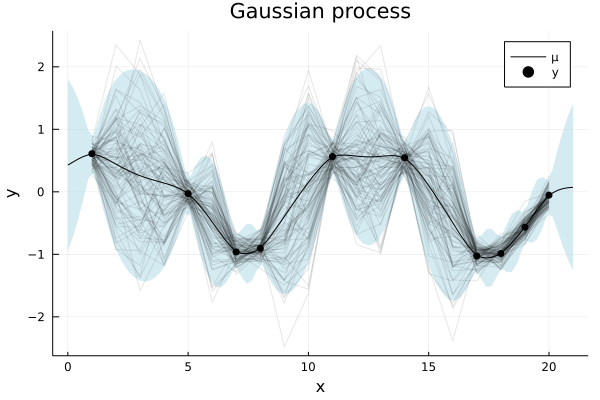

In [60]:
gp = get_gp(ν, ll, lσ)
plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=true, label = ["μ" "y"],
        xlim = [0,maximum(x)+1]) 
plot!(realiz, c = RGBA(0,0,0,0.1), label = "")

## Interpolate using Matérn and Laplace interpolation

Here we assume the Matérn parameters are known and interpolate using them. We need to convert between the log-parameters given to the GP function above and the notation we've used, m, and $\epsilon$. 

In [61]:
h = 1.0

d = 1
# m = nu + d/2
m = 2 
# epsilon = sqrt(2*nu)/length_scale
epsilon = sqrt(3)/exp(ll)

1.0505419189705505

## Benchmark the interpolation

### Laplace interpolation

In [62]:
@benchmark matern_1d_grid(realiz[:,1], discard, 1, 1.0, h)

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):  24.980 μs …   9.542 ms  ┊ GC (min … max): 0.00% … 44.43%
 Time  (median):     29.335 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   36.760 μs ± 224.758 μs  ┊ GC (mean ± σ):  6.89% ±  1.12%

    ▃▇█▇▄▁                                                      
  ▂▅██████▇▆▅▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  25 μs           Histogram: frequency by time         70.8 μs <

 Memory estimate: 45.49 KiB, allocs estimate: 130.

### Matérn interpolation

In [63]:
@benchmark matern_1d_grid(realiz[:,2], discard, m, epsilon, h)

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):  24.462 μs …   7.660 ms  ┊ GC (min … max): 0.00% … 47.15%
 Time  (median):     30.337 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   36.565 μs ± 192.592 μs  ┊ GC (mean ± σ):  6.91% ±  1.31%

   ▂▂   ▁▄▆█▆▇▄▂▂                                               
  ▂██▇▇▆██████████▆▄▃▃▂▂▂▂▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  24.5 μs         Histogram: frequency by time           58 μs <

 Memory estimate: 50.33 KiB, allocs estimate: 131.

In [64]:
μ = mapslices(z -> predict_y(GP(x, z[keep, 1], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1], realiz, dims = 1)

@benchmark predict_y(gp, Float64.(discard))

BechmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.408 μs …  2.428 ms  ┊ GC (min … max): 0.00% … 99.47%
 Time  (median):      9.990 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.268 μs ± 44.883 μs  ┊ GC (mean ± σ):  7.94% ±  1.99%

  ██    ▁▁                                                     
  ██▇▅▃▅████▆▆▄▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  8.41 μs         Histogram: frequency by time        21.9 μs <

 Memory estimate: 10.45 KiB, allocs estimate: 99.

## Accuracy of the approximation

In [65]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1);

Looking at one of the realizations and the interpolation we get, we see that the squared distance between the interpolation and the truth is smaller for the Matérn.

Squared distance between Laplace interpolation and the truth: 7.759755869963926
Squared distance between Matern interpolation and the truth: 6.238715083311265
Squared distance between GP Matern interpolation and the truth: 5.7392506464864566


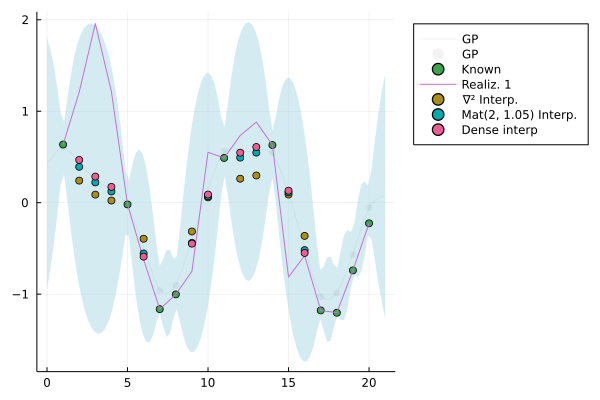

In [66]:
function sqdist(r, interp, discard)
    return sum(abs2, r[discard] .- interp[discard])
end

i = 1

println("Squared distance between Laplace interpolation and the truth: $(sqdist(realiz[:,i], y_lap[:,i], discard))")
println("Squared distance between Matern interpolation and the truth: $(sqdist(realiz[:,i], y_mat[:,i], discard))")
println("Squared distance between GP Matern interpolation and the truth: $(sqdist(realiz[discard,i], μ[:,i], 1:10))")

plot(gp, label = "GP", alpha = 0.05, legend = :outertopright, xlims = [0, maximum(x) + 1])
scatter!(keep, realiz[keep, i], label="Known")
plot!(realiz[:, i], label = "Realiz. $i")
scatter!(discard, y_lap[discard, i], label = "∇² Interp.")
scatter!(discard, y_mat[discard, i], label = "Mat($m, $(round(epsilon, sigdigits = 3))) Interp.")
scatter!(discard, μ[:, i], label = "Dense interp")

Mean squared distance between the Laplacian interpolation and the truth: 4.605760156386393.
Mean squared distance between the Matern interpolation and the truth: 4.348534087555467.
Mean squared distance between the GP interpolation and the truth: 4.343936817105924.


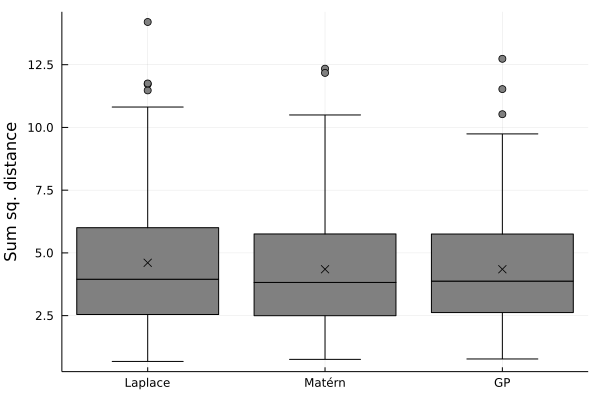

In [69]:
# Compute the squared distance for all the interpolations
lap_dist = map(i -> sqdist(realiz[:, i], y_lap[:, i], discard), 1:nrealiz)
mat_dist = map(i -> sqdist(realiz[:, i], y_mat[:, i], discard), 1:nrealiz)
gp_dist = map(i -> sqdist(realiz[discard, i], μ[:, i], 1:10), 1:nrealiz)

ml = mean(lap_dist)
mm = mean(mat_dist)
mgp = mean(mat_dist)

println("Mean squared distance between the Laplacian interpolation and the truth: $(mean(lap_dist)).")
println("Mean squared distance between the Matern interpolation and the truth: $(mean(mat_dist)).")
println("Mean squared distance between the GP interpolation and the truth: $(mean(gp_dist)).")

p1 = boxplot([lap_dist, mat_dist, gp_dist], label = ["Laplace" "Matern" "GP"], ylabel = "Sum sq. distance",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray)
scatter!(p1, 1:3, [ml, mm, mgp], markershape = :x , c = :black, label = "Mean")